# Parameter estimation in Gaussian mixture models

In [1]:
using DynamicPolynomials
using MultivariateMoments
using SemialgebraicSets

using Distributions
using PDMats

using Plots
using Plots.PlotMeasures
using PyPlot
using Formatting

using HCubature

const MM=MultivariateMoments

include("../src/BeurlingLasso.jl")
using .BeurlingLasso;

In [2]:
pyplot()
PyPlot.matplotlib.rc("text", usetex=true)
PyPlot.matplotlib.rc("font", family="serif")
Plots.scalefontsizes(1.5)

## 1D example

In [3]:
means = [[-0.8], [0.7]]
weights = [0.3, 0.7]

σ = 0.5

natoms = length(means)
ndims = length(means[1])

@polyvar x[1:ndims]
μ0 = AtomicMeasure(x, [WeightedDiracMeasure(means[i], weights[i]) for i=1:natoms]);

In [4]:
identity = ScalMat(ndims, σ^2)
gmm = MixtureModel(MvNormal, [(mean, identity) for mean in means], weights);

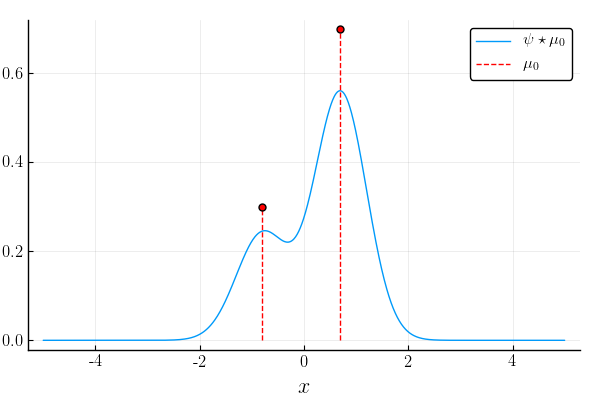

In [5]:
x_tab = -5:0.01:5
y_tab = pdf(gmm, reshape(x_tab, 1, length(x_tab)))

Plots.plot(x_tab, y_tab, label=L"$\psi\star \mu_0$", 
           right_margin=5mm, top_margin=5mm)

plot!([atom.center[1] for atom in μ0.atoms], [atom.weight for atom in μ0.atoms], 
      line=:stem, linestyle=:dash, marker=:circle, 
      markersize=5, color="red", label=L"$\mu_0$")

plot!(xlabel=L"$x$")

## Parameters estimation

Computation of $\Phi\mu_0$ assuming access to $\mu_0$

In [15]:
maxorder = 5

monos = monomials(x, 0:maxorder)
m = length(monos)
y = [MM.expectation(μ0, monos[i]) for i=1:m]

λ = 1e-5;

### Parameters estimation using moments - sums of squares hierarchies

In [16]:
φ = [polynomial(mono) for mono in monos]
domain = @set x[1] <= 1 && x[1] >= -1;

In [17]:
ϵ = 1e-3
solver = momsossolver(ϵ);

In [18]:
prob = blasso(y, φ, λ, domain)
solve!(prob, solver);

In [19]:
prob.μ

Atomic measure on the variables x[1] with 2 atoms:
 at [-0.800004] with weight 0.2999959003542854
 at [0.700002] with weight 0.6999945130169184

### Parameters estimation using the sliding Frank-Wolfe algorithm

In [11]:
φ_func(u, n) = monos[n](x=>u)
domain = reshape([-1, 1], (1, 2));

In [12]:
niter = 2
gridsize = 1000
solver = sfwsolver(niter, gridsize);

In [13]:
prob = blasso(y, φ_func, λ, domain)
solve!(prob, solver);

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/rom1/.julia/packages/Optim/Agd3B/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/rom1/.julia/packages/Optim/Agd3B/src/utilities/perform_linesearch.jl:47


In [14]:
prob.μ

Atomic measure on the variables var[1] with 2 atoms:
 at [0.700002] with weight 0.6999944577872913
 at [-0.800002] with weight 0.2999964387706202

## Moments approximation

$$\int_{\mathcal{X}}\varphi_n(x)~d\mu=\mathbb{E}_{X\sim f_{\mu}}[\phi_n(X)]$$ 

with $\varphi_n(x)=x^n ~ \text{exp}(-\frac{x^2}{2\tau^2})$ and 
$\phi_n(x)\propto H_n\left(\frac{x}{\sqrt{2\sigma^2\left(1-\frac{\sigma^2}{\tau^2}\right)}}\right) 
~ \text{exp}(-\frac{x^2}{2(\tau^2-\sigma^2)})$ 

In [15]:
τ = sqrt(2) * σ;

In [16]:
maxorder = 15
a = computehermite(maxorder)

function hermite(x, n)
    sum(a[n+1, k+1] * x^k for k=0:n)
end

function ϕ(x, n, σ, τ)
    const1 = sqrt(τ^2/(τ^2-σ^2))
    const2 = sqrt(σ^2/(2*(1-σ^2/τ^2)))^n
    expterm = exp(-x^2/(2*(τ^2-σ^2)))
    hterm = hermite(x/sqrt(2*σ^2*(1-σ^2/τ^2)), n)
    regconst = sqrt(2^n * factorial(n) * sqrt(π))
    const1 * const2 * expterm * hterm / regconst
end;

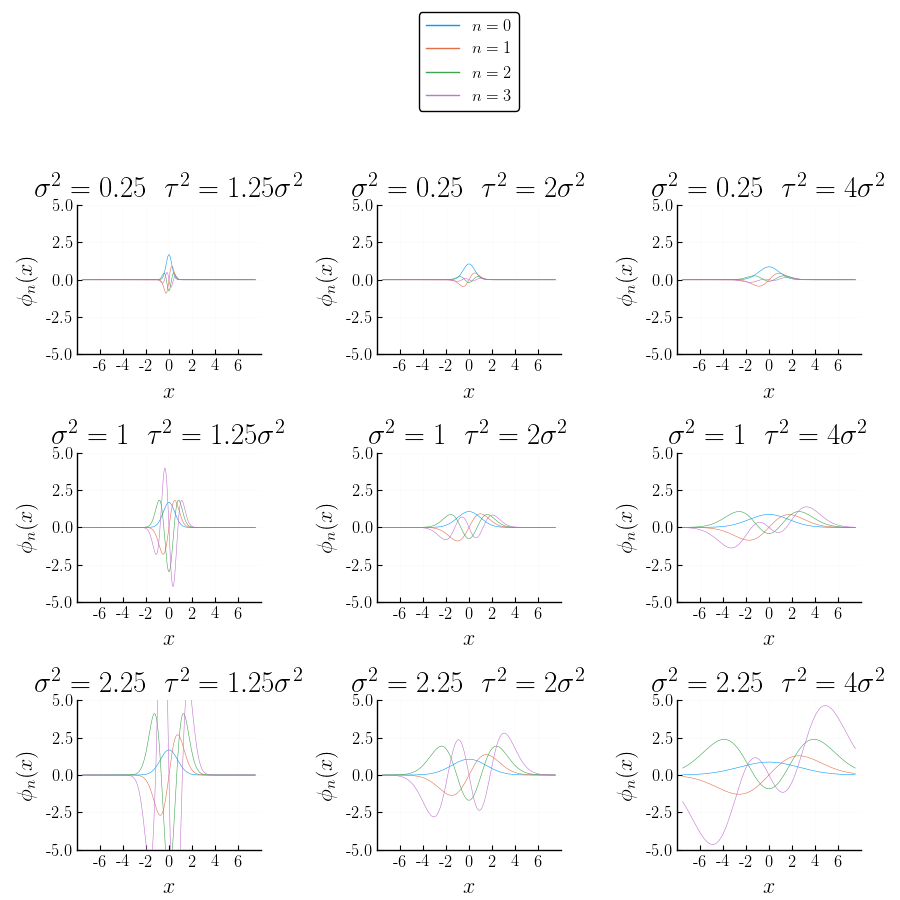

In [17]:
felab = FormatExpr(L"$n={}$")
fetitle = FormatExpr(L"$\sigma^2={1}~~\tau^2={2}\sigma^2$")

x_tab = -7.5:0.01:7.5
n_tab = [0 1 2 3]

function plot_ϕ(σ, k)
    y_tab = hcat([[ϕ(x, n, σ, sqrt(k)*σ) for x in x_tab] for n in n_tab]...)
    
    Plots.plot(x_tab, y_tab, ylims=(-5, 5),
               xlabel=L"x", ylabel=L"\phi_n(x)", 
               top_margin=5mm, right_margin=10mm,
               title=format(fetitle, σ^2, k), legend=false, 
               gridcolor="lightgrey", linewidth=0.4)
end


p1 = plot_ϕ(0.5, 1.25)
p2 = plot_ϕ(0.5, 2)
p3 = plot_ϕ(0.5, 4)

p4 = plot_ϕ(1, 1.25)
p5 = plot_ϕ(1, 2)
p6 = plot_ϕ(1, 4)

p7 = plot_ϕ(1.5, 1.25)
p8 = plot_ϕ(1.5, 2)
p9 = plot_ϕ(1.5, 4)

l = @layout[a; [b c d]; [e f g]; [h i j]]

Plots.plot(Plots.plot((1:4)', label=hcat([format(felab, n) for n in n_tab]...), 
           legend = :top, framestyle = :none), 
           p1, p2, p3, p4, p5, p6, p7, p8, p9,
           layout=l, size = (900, 900), link=:y,
           left_margin=5mm, right_margin=10mm)

Computation of $\text{Var}_{X\sim f_{\mu}}[\phi_n(X)]$

In [18]:
squared_exp = [hquadrature(u -> ϕ(u, n, σ, τ)^2 * pdf(gmm, [u]), -10, 10)[1] for n in n_tab]
exp_squared = [hquadrature(u -> ϕ(u, n, σ, τ)^2 * pdf(gmm, [u]), -10, 10)[1]^2 for n in n_tab]
var = squared_exp .- exp_squared

1×4 Array{Float64,2}:
 0.217791  0.0828005  0.0212145  0.00481988

The variance seems to decrease with $n$

Approximation of $\mathbb{E}_{X\sim f_{\mu}}[\phi_n(X)]$ by $\frac{1}{N}\sum\limits_{i=1}^N\phi_n(X_i)$ 
with $X_1,...,X_n$ iid,  $X_i\sim f_{\mu}$

In [19]:
nsamples = 1000
samples = rand(gmm, nsamples);

In [20]:
moments_estim = [sum(ϕ(u, n, σ, τ) for u in samples) / nsamples for n in n_tab];

Approximation of $\mathbb{E}_{X\sim f_{\mu}}[\phi_n(X)]$ by 
$\int_{\mathcal{X}}\phi_n(x) ~ f_{\mu}(x)~dx$ (really reliable, will be considered ground truth)

In [21]:
moments_quad = [hquadrature(u -> ϕ(u, n, σ, τ) * pdf(gmm, [u]), -10, 10)[1] for n in n_tab];

In [22]:
abs.(moments_estim .- moments_quad) ./ moments_quad

1×4 Array{Float64,2}:
 0.027233  0.062885  0.10712  0.598855

The estimation's relative precision however decreases with $n$, because moments become really small

In [23]:
nsamples = 1000000
samples = rand(gmm, nsamples)
moments_estim = [sum(ϕ(u, n, σ, τ) for u in samples) / nsamples for n in n_tab]

abs.(moments_estim .- moments_quad) ./ moments_quad

1×4 Array{Float64,2}:
 5.67489e-6  0.00226838  0.000836327  0.00131856

Increasing the number of samples yields a better precision, but convergence is extremly slow for higher order moments